In [1]:
import sys
sys.path.insert(1, '/home/amrzr/Work/Codes/Offline_IMOEA_Framework/')

from desdeo_problem.Problem import DataProblem
import pickle
from desdeo_problem.testproblems.TestProblems import test_problem_builder
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from main_project_files.surrogate_fullGP import FullGPRegressor as fgp
from desdeo_problem.surrogatemodels.SurrogateModels import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.ensemble import RandomForestClassifier

#from pygmo import non_dominated_front_2d as nd2
from other_tools.non_domx import ndx
import scipy.io
from sklearn.neighbors import NearestNeighbors
import time
import GPy
#from BIOMA_framework import interactive_optimize
from BIOMA_framework_worst import interactive_optimize
from BIOMA_framework_worst import full_optimize
import copy

from scipy.stats import qmc

In [2]:
max_iters = 5 #5 #50
gen_per_iter= 5 #10
is_interact = False

nobjs = 2
nvars = 4 #4 #10 
N = 450
px=0.5 #0.0

dtlz2 = test_problem_builder("DTLZ2", n_of_objectives= nobjs, n_of_variables=nvars)
sampler = qmc.LatinHypercube(d=nvars)
dtlz_data = sampler.random(n=N)
#dtlz_data = np.random.random((N,nvars))
dtlz_obj_val = dtlz2.evaluate(dtlz_data)

bound_val1=0.02
bound_val2=0.68 #20: 0.94 #0.68 #10: 0.87 #4: 0.68
bound1 = np.ones(nvars)*bound_val1
bound1 = np.tile(bound1,(N,1))
bound2 = np.ones(nvars)*bound_val2
bound2 = np.tile(bound2,(N,1))
failed_loc = np.where(np.all(dtlz_data >= bound1, axis=1) & np.all(dtlz_data <= bound2, axis=1))
stat_success = np.ones((N,1))
stat_success[failed_loc,0]=0

obj_vals = dtlz_obj_val[0]
obj_success = obj_vals[np.where(stat_success==1)[0],:]

np.size(failed_loc)
print(np.size(failed_loc))

# # main_directory = 'Pump_Test_Tomas_2_140'
data_folder = '/home/amrzr/Work/Codes/data'
# path = data_folder + '/test_runs/' + main_directory
# data_file = 'DOE_test_successful.csv'

main_directory = 'DTLZ2_test'
#data_folder = '/home/Jana/Pump/Offline/data'
path = data_folder + '/test_runs/' + main_directory


# model_file = 'Dataset_140'
model_file = 'DTZL2'
read_saved_models = True

#selection_type = 'prob_only'  # proba
#selection_type = 'prob_class_v1'
selection_type = 'prob_class_v2'
#selection_type = 'generic'


x_low_new = np.ones(nvars)*0
x_high_new = np.ones(nvars)

def build_classification_failed():
    X=dtlz_data
    y=stat_success.flatten()
    
    labels = list(set(y.flatten()))
    models = {}
    for label in labels:
        ytmp=y.copy()
        ytmp[ytmp!=label]=0
        ytmp[ytmp==label]=1
        kernel = GPy.kern.Matern52(np.shape(X)[1], ARD=True)
        m=GPy.models.GPClassification(X, ytmp[:, None], kernel=kernel)
        
        m.optimize_restarts(messages=False, robust=True, 
                            num_restarts=4
                            )
        #    else:
        #        m.optimize(messages=True)
        models[label]=m
    return models[1]


def run_optimizer_approach_interactive(problem, classification_model, path):
    print("Optimizing...")
    evolver_opt = interactive_optimize(problem, classification_model, gen_per_iter, max_iters, path)
    return evolver_opt.population

def run_optimizer_approach_full(problem, classification_model, path, selection_type):
    print("Optimizing...")
    evolver_opt = full_optimize(problem, classification_model, gen_per_iter, max_iters, path, selection_type)
    return evolver_opt.population

# def scale_data(data):
#     x_data = np.asarray(data.loc[:,:'x22'])
#     x_data_scaled = (x_data - x_low)/(np.asarray(x_high) - np.asarray(x_low))
#     data.loc[:,:'x22'] = x_data_scaled
#     return data

def build_surrogates(nobjs, nvars, df): #x_data, y_data):
    print("Building surrogates...")
    x_names = list(df.columns)[0:nvars] #J
    y_names = list(df.columns)[nvars:nvars+nobjs] #J
    row_names = ['lower_bound','upper_bound']
    #data = pd.DataFrame(np.hstack((x_data,y_data)), columns=x_names+y_names)
    data = df
    print(data)

    bounds = pd.DataFrame(np.vstack((x_low_new,x_high_new)), columns=x_names, index=row_names)
    problem = DataProblem(data=df, variable_names=x_names, objective_names=y_names,bounds=bounds)
    start = time.time()
    problem.train(fgp)
    #problem.train(GaussianProcessRegressor) #, {"kernel": Matern(nu=3/2)})
    end = time.time()
    time_taken = end - start
    return problem

92


In [3]:
data_scaled=pd.DataFrame(np.concatenate((dtlz_data[np.where(stat_success==1)[0],:], obj_success), axis=1))


if read_saved_models:
    data_file = data_folder+ '/test_runs/test_models/' + model_file
    infile = open(data_file, 'rb')
    results_data = pickle.load(infile)
    infile.close()
    surrogate_problem = results_data["surrogate_problem"]
    print("loaded saved models...")
else:
    surrogate_problem = build_surrogates(nobjs, nvars, data_scaled)
classification_model = build_classification_failed()
#print(surrogate_problem.objectives[2]._model.predict(np.asarray(data_scaled.loc[0:1,:'x22'])))
#print(surrogate_problem.objectives[2]._model.predict(np.asarray(x_low_new).reshape(1,-1)))
#print(surrogate_problem.objectives[2]._model.predict(zz))
if is_interact:
    population = run_optimizer_approach_interactive(surrogate_problem, classification_model, path)
else:
    population = run_optimizer_approach_full(surrogate_problem, classification_model, path, selection_type)


results_dict = {
        'individual_archive': population.individuals_archive,
        'objectives_archive': population.objectives_archive,
        'uncertainty_archive': population.uncertainty_archive,
        'individuals_solutions': population.individuals,
        'obj_solutions': population.objectives,
        'uncertainty_solutions': population.uncertainity                
    }
outfile = open(path+'/run_dtlz2', 'wb')
pickle.dump(results_dict, outfile)
outfile.close()


if read_saved_models is False:
    surrogate_problem_copy = copy.deepcopy(surrogate_problem)
    #classification_model_copy = copy.deepcopy(classification_model)
    models_dict = {
            'surrogate_problem': surrogate_problem_copy
            #'classification_model': classification_model_copy           
        }

    # path = data_folder + '/test_runs/Pump_models'
    path = data_folder + '/test_runs/test_models'
    outfile = open(path+'/' + model_file, 'wb')
    pickle.dump(models_dict, outfile)
    outfile.close()
    

loaded saved models...
Optimization restart 1/4, f = 2.0868770171509823
Optimization restart 2/4, f = 9.563296338276075
Optimization restart 3/4, f = 4.8598058934719575
Optimization restart 4/4, f = 5.902516283105001
Optimization restart 1/4, f = 117.5691388492126
Optimization restart 2/4, f = 117.5206778411297
Optimization restart 3/4, f = 118.0881505755774
Optimization restart 4/4, f = 111.4409958761596
Optimizing...
Pop size: (100, 2)
Class prob size: (100, 1)


IndexError: index 0 is out of bounds for axis 0 with size 0

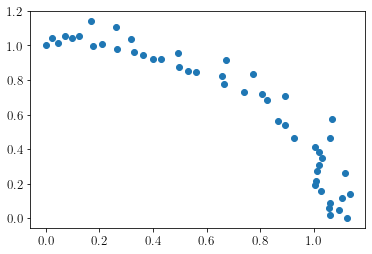

In [11]:
plt.scatter(population.objectives[:,0],population.objectives[:,1])
plt.show()

In [ ]:
exactval=dtlz2.evaluate(population.individuals)
# solval=population.objectives
solval=exactval[0]

par_where=ndx(solval)[0]
nondom_population=population.individuals[par_where[0]]
nondom_objectives=solval[par_where[0]]

Bound1 = np.ones(nvars)*bound_val1
Bound2 = np.ones(nvars)*bound_val2

failed_loc_pop_nds= np.where(np.all(nondom_population>= Bound1, axis=1) & np.all(nondom_population <= Bound2, axis=1))
stat_success_pop_all = np.ones((np.shape(nondom_population)[0],1))
stat_success_pop_all[failed_loc_pop_nds,0]=0
pop_success=nondom_population[np.where(stat_success_pop_all==1)[0],:]
# obj_success_pop_all = population.objectives[np.where(stat_success_pop_all==1)[0],:]
obj_success_pop_nds=dtlz2.evaluate(pop_success)[0]


failed_loc_pop= np.where(np.all( nondom_population>= Bound1, axis=1) & np.all(nondom_population <= Bound2, axis=1))
print(np.shape(failed_loc_pop))
print(np.shape(nondom_population))


#
# pareto set
dtlz_par = np.hstack((np.random.random((int(N), nobjs-1)),(np.ones((int(N),nvars-nobjs+1))*px)))
failed_loc2 = np.where(np.all(dtlz_par >= bound1, axis=1) & np.all(dtlz_par <= bound2, axis=1))
stat_success = np.ones((N,1))
stat_success[failed_loc2,0]=0
dtlz_par_val = dtlz2.evaluate(dtlz_par)
par_vals = dtlz_par_val[0]
obj_success = par_vals[np.where(stat_success==1)[0],:]

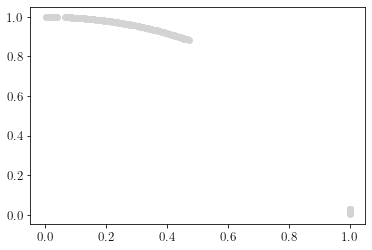

In [3]:
# true pareto #
plt.scatter(obj_success[:,0], obj_success[:,1],c='lightgray')
plt.show()


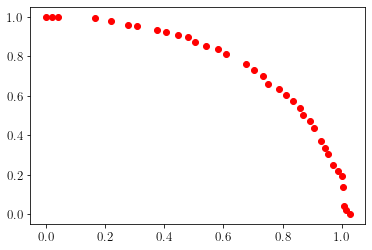

In [2]:

# solutions

# plt.scatter(exactval[0][:,0], exactval[0][:,1],c='blue')
# plt.show()

# plt.scatter(population.objectives[:,0], population.objectives[:,1],c='blue')
# plt.show()



# nondominated solutions
plt.scatter(nondom_objectives[:,0], nondom_objectives[:,1],c='red')
plt.show()



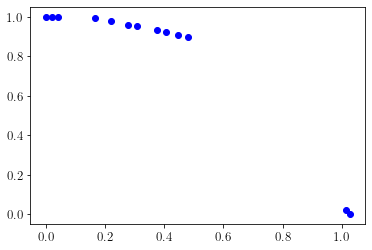

In [4]:
# good solutions
plt.scatter(obj_success_pop_nds[:,0], obj_success_pop_nds[:,1],c='blue')
plt.show()

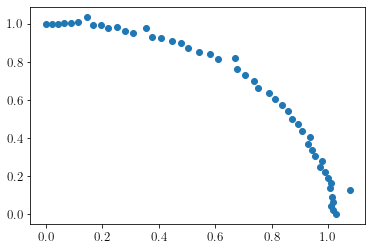

In [15]:
y=stat_success.flatten()
labels = list(set(y.flatten()))

In [17]:
classification_model.predict(population.individuals) 

(array([[0.98077945],
        [0.75532278],
        [0.7025799 ],
        [0.7020141 ],
        [0.60819457],
        [0.51375874],
        [0.97965911],
        [0.97789244],
        [0.40736033],
        [0.91719798],
        [0.40234215],
        [0.66456662],
        [0.30218933],
        [0.72539168],
        [0.86298411],
        [0.97749936],
        [0.60892131],
        [0.88746215],
        [0.94715903],
        [0.56547993],
        [0.90976819],
        [0.60669447],
        [0.83171158],
        [0.94728586],
        [0.97367777],
        [0.90894917],
        [0.97725222],
        [0.55614128],
        [0.81373337],
        [0.48468092],
        [0.51828735],
        [0.4272493 ],
        [0.9815895 ],
        [0.6816122 ],
        [0.35494113],
        [0.83404276],
        [0.92735073],
        [0.53927317],
        [0.67286934],
        [0.6002981 ],
        [0.58877064],
        [0.61547672],
        [0.65000545],
        [0.82039748],
        [0.37882063],
        [0